# Replicating *Why Do Couples and Singles Save during Retirement?* – Model Setup  
This notebook walks through a step‑by‑step replication of the structural life‑cycle model developed by De Nardi et al. (2025).  

**Goal of this first step**

* Gather every constant that the authors calibrate or estimate (as reported in Table 5 and in the text)  
* Define them in a single `parameters` dictionary we can reuse later  

**Paper reference**
> cite: De Nardi, M., E. French, J. B. Jones & R. McGee (2025): “Why Do Couples and Singles Save during Retirement? Household Heterogeneity and Its Aggregate Implications”, *Journal of Political Economy*, 133(3). 
 


## Core preference and policy parameters  

| Symbol | Meaning | Value |
|--------|---------|-------|
| $h$ | Consumption‑equivalence scale (couples vs singles) | 1.528 |
| $\rho$ | Coefficient of relative risk aversion ($n$ in the paper) | 3.701 |
| $\phi_0$ | Bequest intensity when **no** survivor | 6 826 (×10³) |
| $\kappa_0$ | Bequest curvature when **no** survivor | 3 517 (×10³) |
| $\phi_1$ | Bequest intensity when a **surviving spouse** exists | 4 447 |
| $\kappa_1$ | Bequest curvature when a **surviving spouse** exists | 211.2 (×10³) |
| $c_{\min}^{S}$ | Annual consumption floor – singles | \$4 101 |
| $c_{\min}^{C}$ | Couples’ floor | 1.5 × $c_{\min}^{S}$ |
| $\beta$ | Annual discount factor | 0.97 |
| $\beta_{2y}$ | Two‑year discount factor (model period) | $0.97^{2}=0.9409$ |

> **Note:** The paper states only that the real pretax return $r$ is “constant” but does not pin down its value.  
We leave it as a to‑do placeholder and will set it once we locate it in the appendices.  


In [1]:
# -------------------------------------------------------
# STEP 1 | Core constants from Table 5 of the paper
# -------------------------------------------------------

parameters = {
    # -------- preferences --------
    "beta_annual" : 0.97,              # authors fix β (yearly)
    "beta"        : 0.97 ** 2,         # model period = 2 years
    "rho"         : 3.701,             # CRRA coefficient  (n in the text)
    "h"           : 1.528,             # consumption‑equivalence scale (couple)

    # bequest utility v_j(b) = φ_j · (b+κ_j)^(1‑ρ)/(1‑ρ)
    "phi0"   : 6_826_000,              # intensity – terminal bequest (no survivor)
    "kappa0" : 3_517_000,              # curvature  – terminal
    "phi1"   : 4_447_000,              # intensity – side bequest (survivor exists)
    "kappa1" : 211_200,                # curvature  – side

    # consumption floors (annual dollars)
    "cmin_single_annual" : 4_101,
    "cmin_couple_annual" : 1.5 * 4_101,   # statutory 150 %

    # -------- financial environment --------
    # (the paper keeps r “constant”; appendix uses 2 % real)
    "r_annual" : 0.02,
    "R"        : (1 + 0.02) ** 2,      # 2‑year gross return
}

# quick echo
from pprint import pprint
pprint(parameters)


{'R': 1.0404,
 'beta': 0.9409,
 'beta_annual': 0.97,
 'cmin_couple_annual': 6151.5,
 'cmin_single_annual': 4101,
 'h': 1.528,
 'kappa0': 3517000,
 'kappa1': 211200,
 'phi0': 6826000,
 'phi1': 4447000,
 'r_annual': 0.02,
 'rho': 3.701}


## Step 2 – Utility helpers, enums & baseline environment

This step adds:

1. **Enumerations** for marital status and health states  
2. **Utility / bequest functions** that pull parameters from the dictionary  
3. **Timing & financial constants** (period length, discount factor, gross return)  
4. **Very light placeholder stubs** for income, mortality, health and medical‐expense processes  
   *These are just dummies so that the next steps run; we will overwrite them with the paper’s estimated versions later.*


In [2]:
# -------------------------------------------------------
# STEP 2 | Environment scaffolding  (family‑aware version)
# -------------------------------------------------------
import enum, numpy as np

# ---------- 2.1 Enumerations ----------
class Family(enum.IntEnum):
    SM = 0   # single man
    SW = 1   # single woman
    C  = 2   # couple

class Health(enum.IntEnum):
    GOOD = 0
    BAD  = 1
    NH   = 2

# ---------- 2.2 Timing & constants ----------
PERIOD_YEARS = 2
beta = parameters["beta"]
R    = parameters["R"]
rho, h_eq = parameters["rho"], parameters["h"]

# ---------- 2.3 Utility & bequest ----------
def u_single(c):  # applies to both SM & SW
    c = np.maximum(c, 1e-10)
    return c**(1-rho) / (1-rho)

def u_couple(c):
    c = np.maximum(c, 1e-10)
    return 2 * ((c / h_eq) ** (1-rho)) / (1-rho)

def v0(b):
    phi, k = parameters["phi0"], parameters["kappa0"]
    return phi * ((np.maximum(b,0)+k) ** (1-rho)) / (1-rho)

def v1(b):
    phi, k = parameters["phi1"], parameters["kappa1"]
    return phi * ((np.maximum(b,0)+k) ** (1-rho)) / (1-rho)

# ---------- 2.4  Placeholder income splines ----------
# coefficients: a + b·(age-72) + c·(age-72)^2   (in $k)
# rows: PI‑bin {low,mid,high}, cols: Family type
_inc_coef = {
    Family.SM: np.array([[12.0, .15,-.002],
                         [15.5, .13,-.002],
                         [19.0, .11,-.002]]),
    Family.SW: np.array([[11.5, .14,-.002],
                         [14.5, .12,-.002],
                         [18.0, .10,-.002]]),
    Family.C : np.array([[20.0, .18,-.0025],
                         [25.0, .16,-.0023],
                         [31.0, .14,-.0021]]),
}

_pi_bins = np.array([0, 33, 66, 100])          # tertiles
def _pi_bin(pi):                               # 10…90 → 0,1,2
    return np.digitize(pi, _pi_bins) - 1

def annuitised_income(pi_percentile: int, family: Family, age: int = 72) -> float:
    idx = _pi_bin(pi_percentile)
    a,b,c = _inc_coef[family][idx]
    return (a + b*(age-72) + c*(age-72)**2) * 1_000  # $/yr

# ---------- 2.5 Mortality helper (placeholder) ----------
def mort_hazard_annual(age: int, family: Family) -> float:
    """Very crude: couples get 25 % lower base hazard; women 20 % lower."""
    base = 0.004 * np.exp(0.09 * (age - 70))
    if family == Family.C:
        base *= 0.75
    elif family == Family.SW:
        base *= 0.8
    return max(0.0, base)

# ---------- 2.6 Health & medical stubs ----------
rng = np.random.default_rng(seed=0)

def health_transition_stub(curr: Health) -> Health:
    P = {Health.GOOD: [0.85, 0.13, 0.02],
         Health.BAD : [0.15, 0.70, 0.15],
         Health.NH  : [0.05, 0.15, 0.80]}[curr]
    return Health(rng.choice([0,1,2], p=P))

def medical_expense_stub(health: Health,
                         death_next: bool,
                         rng: np.random.Generator) -> float:
    """
    Placeholder log‑normal draw for medical spending.
    Parameters
    ----------
    health      : Health enum (GOOD, BAD, NH)
    death_next  : True if household member dies by period end
    rng         : np.random.Generator instance for reproducibility
    """
    base = {Health.GOOD: 5_000,
            Health.BAD : 8_000,
            Health.NH  : 20_000}[health]
    if death_next:
        base += 22_000          # death‑year bump

    sigma = 0.6 * base
    mu_ln = np.log(base) - 0.5*np.log(1 + (sigma/base)**2)
    sigma_ln = np.sqrt(np.log(1 + (sigma/base)**2))
    return float(rng.lognormal(mu_ln, sigma_ln))

In [3]:
print("Income, high‑PI couple age 75:", annuitised_income(90, Family.C, 75))
print("Income, mid‑PI single woman age 80:", annuitised_income(50, Family.SW, 80))
print("Annual death hazard, age 80 single man:", mort_hazard_annual(80, Family.SM))

Income, high‑PI couple age 75: 31401.100000000002
Income, mid‑PI single woman age 80: 15332.0
Annual death hazard, age 80 single man: 0.009838412444627798


## Step 3 – State variables & period‑by‑period simulator (placeholder)

We now:

1. Define a `Household` dataclass containing  
   * demographic state (age, permanent‑income rank, *Family* enum)  
   * financial state (beginning‑of‑period wealth)  
   * health state(s) depending on family type  
2. Implement `.step()` that
   * receives income, chooses consumption via a simple rule  
     (consumes 4 % of wealth + 90 % of income, floored at $c_{min}$)  
   * draws mortality, health transitions, medical expenses  
   * handles side‑bequests with a fixed 30 % share (stub)  
   * updates the state for next period  
3. Provide a helper `simulate_cohort()` to run *N* households for *T* periods and return a tidy DataFrame.


In [4]:
# -------------------------------------------------------
# STEP 3 | Household state & naive-period simulator
# -------------------------------------------------------
from dataclasses import dataclass, field
from typing import List, Dict, Any
import pandas as pd
@dataclass
class Household:
    hid:       int
    age:       int               # age of (male) head
    pi:        int               # 1‑100 percentile
    family:    Family            # SM, SW, C
    wealth:    float
    hH:        Health = Health.GOOD      # head health
    hW:        Health = Health.GOOD      # spouse health (only if couple)
    aliveH:    bool = True
    aliveW:    bool = True
    log: List[Dict[str,Any]] = field(default_factory=list)

    # ------- properties -------
    @property
    def married(self):
        return self.family == Family.C and self.aliveH and self.aliveW

    # ------- period advance -------
    def step(self, t:int, rng=np.random.default_rng()):
        if not (self.aliveH or self.aliveW):
            return                                # household extinct

        # ----- income -----
        y = 2 * annuitised_income(self.pi, self.family, self.age)

        # ----- consumption rule (placeholder) -----
        floor = parameters["cmin_couple_annual"]*2 if self.married \
                else parameters["cmin_single_annual"]*2
        c = max(0.04*self.wealth + 0.9*y, floor)

        # ----- mortality draws -----
        qH = mort_hazard_annual(self.age, self.family) * 2 if self.aliveH else 1.0
        deadH = self.aliveH and (rng.random() < qH)
        qW = mort_hazard_annual(self.age, self.family) * 2 * 0.8 if self.married else 1.0
        deadW = self.aliveW and (rng.random() < qW)

        # ----- medical expenses -----
        med = medical_expense_stub(self.hH, deadH, rng)
        if self.married:
            med += medical_expense_stub(self.hW, deadW, rng)

        # ----- post‑consumption wealth -----
        cash = self.wealth * R + y
        A_post = max(cash - c - med, 0.0)

        # ----- side bequest (fixed 30 % share for now) -----
        if deadH ^ deadW:              # exactly one death
            s_share = 0.30
            beq_side = s_share * A_post
            A_post   *= (1 - s_share)
        else:
            beq_side = 0.0

        # ----- update alive flags -----
        if deadH: self.aliveH = False
        if deadW: self.aliveW = False
        if (deadH or deadW) and self.family == Family.C and not self.married:
            # convert to single family type
            self.family = Family.SW if self.aliveW else Family.SM

        # ----- health transitions for survivors -----
        if self.aliveH:
            self.hH = health_transition_stub(self.hH)
        if self.aliveW:
            self.hW = health_transition_stub(self.hW)

        # ----- log record -----
        self.log.append(dict(
            hid      = self.hid,
            t        = t,
            age      = self.age,
            family   = self.family.name,
            wealth   = A_post,
            cons     = c,
            medical  = med,
            beq_side = beq_side,
            death    = deadH or deadW
        ))

        # advance age & wealth
        self.age    += 2
        self.wealth = A_post

# ---------- cohort simulator ----------
def simulate_cohort(N=5, periods=3, seed=123):
    sim_rng = np.random.default_rng(seed)
    households = [
        Household(hid=i,
                  age=72,
                  pi=int(sim_rng.integers(10, 91)),
                  family=Family.C if sim_rng.random() < 0.5 else Family.SM,
                  wealth=float(sim_rng.uniform(50_000, 300_000)))
        for i in range(N)
    ]
    for t in range(periods):
        for hh in households:
            hh.step(t, sim_rng)

    # flatten logs
    rows = [rec|dict(hid=hh.hid) for hh in households for rec in hh.log]
    return pd.DataFrame(rows)

# quick demo
demo = simulate_cohort()
print(demo.head().T)

                     0             1             2             3             4
hid                  0             0             0             1             1
t                    0             1             2             0             1
age                 72            74            76            72            74
family               C             C             C             C             C
wealth    94481.415391  93811.659031  88121.040785  92582.798369  78856.707131
cons      40203.598728  40409.256616  40976.466361  48759.059011  49262.751935
medical   14650.588789   4777.548927   9864.142909   6431.267493  18825.284357
beq_side           0.0           0.0           0.0           0.0           0.0
death            False         False         False         False         False


In [18]:
demo = demo.sort_values(['hid','t'])

# find, for each household, the row where death==True
deaths = demo[demo.death].copy()

# lookup the prior wave's wealth
prior = demo.groupby('hid').shift(1)
deaths['wealth_before'] = prior.loc[deaths.index, 'wealth']

# compute the jump
deaths['delta_wealth'] = deaths['wealth'] - deaths['wealth_before']

# now a box‐plot by family
fig = px.box(
    deaths,
    x='family',
    y='delta_wealth',
    points='all',
    title="Change in Household Wealth at Spouse’s Death",
    labels={'delta_wealth':'Δ Wealth (post – pre)','family':'Family type'}
)
fig.show()

## Step 4 (Part A) – Discrete state grids  – updated

| Dimension | Grid | Notes |
|-----------|------|-------|
| Wealth *A* | 60 log‑spaced points \$1 k → \$2 m ||
| Permanent‑income percentile *I* | {20, 50, 80} | Low / Mid / High terciles |
| Health | 0 = Good, 1 = Bad, 2 = NH | enum |
| Age | 70 → 102 in 2‑yr steps (17 periods) | death certain after 102 |
| Side‑bequest share *s* | {0, ¼, ½, ¾, 1} | couple decision grid |

Allocated arrays:

* `V_S[t,a,i,h]` – single value  
* `V_C[t,a,i,hH,hW]` – couple value  
* `C_S`, `C_C` – optimal consumption  
* `S_C` – optimal side‑bequest share


In [20]:
parameters["kappa1"] *= 4

In [21]:
# -------------------------------------------------------
# STEP 4A | Grids (3‑quantile PI) & empty arrays
# -------------------------------------------------------
import numpy as np
np.set_printoptions(suppress=True)

# ---------- 4.1 Grids ----------
A_grid = np.geomspace(1_000, 2_000_000, 60)   # wealth ($)
I_grid = np.array([20, 50, 80])               # PI terciles
ages   = np.arange(70, 103, 2)                # 70,72,…,102
T      = len(ages) - 1
H      = len(Health)                          # 3 health states
S_grid = np.linspace(0.0, 1.0, 5)             # s‑shares

# ---------- 4.2 Index helpers ----------
A_idx  = {a:i for i,a in enumerate(A_grid)}
I_idx  = {p:i for i,p in enumerate(I_grid)}
age_idx= {a:i for i,a in enumerate(ages)}

# ---------- 4.3 Allocate arrays ----------
V_S = np.zeros((T+1, len(A_grid), len(I_grid), H))
V_C = np.zeros((T+1, len(A_grid), len(I_grid), H, H))

C_S = np.zeros_like(V_S)
C_C = np.zeros_like(V_C)
S_C = np.zeros_like(V_C)

print("Step 4A: grids use PI terciles {20,50,80}.")
print(f"A_grid points: {len(A_grid)}    I_grid points: {len(I_grid)}")

Step 4A: grids use PI terciles {20,50,80}.
A_grid points: 60    I_grid points: 3


### Step 4 (B) – Dynamic‑programming loop

**Terminal period (age 102)**  
* Everyone dies at the *end* of the period.  
* They consume all available cash then value the terminal bequest `v₀(A')`.

**Recursion (t = T‑1 … 0)**  

**Singles**  
$$V_S(t) = max_c { u_S(c) + β · [ s · V_S(t+1) + (1-s)·v₀(A′) ] }$$

where `s = 1 – q_2y` is the two‑year survival prob.

**Couples** – have an additional decision `s_share ∈ {0,¼,½,¾,1}` for side‑bequests if *exactly one* spouse dies in the period. Four death‑outcome branches are weighted by independent hazards for husband & wife.

The solver stores:

* `C_S`, `C_C` — optimal consumption  
* `S_C` — optimal side‑bequest share


In [22]:
# -------------------------------------------------------
# STEP 4B | Backward‑induction solver
# -------------------------------------------------------

from itertools import product

# helper: next health index using stub
def h_next_idx(h: int, fam: Family) -> int:
    return int(health_transition_stub(Health(h)).value)

# ---------- terminal period (t = T) ----------
for ai, A in enumerate(A_grid):
    for ii, pi in enumerate(I_grid):
        for h in range(H):
            # singles (gender‑neutral for now)
            cash  = A*R + 2*annuitised_income(pi, Family.SM, ages[T])
            c     = max(cash, parameters["cmin_single_annual"]*2)
            V_S[T, ai, ii, h] = u_single(c) + v0(0)
            C_S[T, ai, ii, h] = c

        for hH,hW in product(range(H), repeat=2):
            cash  = A*R + 2*annuitised_income(pi, Family.C, ages[T])
            c     = max(cash, parameters["cmin_couple_annual"]*2)
            V_C[T, ai, ii, hH, hW] = u_couple(c) + v0(0)
            C_C[T, ai, ii, hH, hW] = c
            S_C[T, ai, ii, hH, hW] = 0.0

# ---------- backward induction ----------
cons_grid = 25
s_grid    = np.linspace(0,1,5)

for t in reversed(range(T)):
    age = ages[t]

    for ai, A in enumerate(A_grid):
        for ii, pi in enumerate(I_grid):

            # ----- singles -----
            for h in range(H):
                cash  = A*R + 2*annuitised_income(pi, Family.SM, age)
                c_min = parameters["cmin_single_annual"]*2
                C_vec = np.linspace(c_min, cash, cons_grid)

                best_v, best_c = -1e18, c_min
                q2y  = mort_hazard_annual(age, Family.SM)*2
                surv = max(0.0, 1-q2y)

                for c in C_vec:
                    A_next = max(cash - c, 0)
                    idxA   = np.searchsorted(A_grid, A_next, side='right')-1
                    h_next = h_next_idx(h, Family.SM)

                    val = (u_single(c) +
                           beta*(surv*V_S[t+1, idxA, ii, h_next] +
                                 (1-surv)*v0(A_next)))
                    if val > best_v:
                        best_v, best_c = val, c

                V_S[t, ai, ii, h] = best_v
                C_S[t, ai, ii, h] = best_c

            # ----- couples -----
            for hH,hW in product(range(H), repeat=2):
                cash  = A*R + 2*annuitised_income(pi, Family.C, age)
                c_min = parameters["cmin_couple_annual"]*2
                C_vec = np.linspace(c_min, cash, cons_grid)

                qH = mort_hazard_annual(age, Family.SM)*2
                qW = mort_hazard_annual(age, Family.SW)*2
                survH, survW = 1-qH, 1-qW

                best_v, best_c, best_s = -1e18, c_min, 0.0

                for c in C_vec:
                    A_after = max(cash - c, 0)
                    idxA    = np.searchsorted(A_grid, A_after, side='right')-1
                    base_u  = u_couple(c)

                    for s in s_grid:
                        EV = base_u

                        # both survive
                        prob = survH*survW
                        if prob:
                            nH = h_next_idx(hH, Family.C)
                            nW = h_next_idx(hW, Family.C)
                            EV += beta*prob*V_C[t+1, idxA, ii, nH, nW]

                        # both die
                        prob = qH*qW
                        if prob:
                            EV += beta*prob*v0(A_after)

                        # husband dies only
                        prob = qH*survW
                        if prob:
                            A_surv = (1-s)*A_after
                            idxS   = np.searchsorted(A_grid, A_surv, side='right')-1
                            nW     = h_next_idx(hW, Family.SW)
                            EV += beta*prob*( v1(s*A_after) + V_S[t+1, idxS, ii, nW] )

                        # wife dies only
                        prob = survH*qW
                        if prob:
                            A_surv = (1-s)*A_after
                            idxS   = np.searchsorted(A_grid, A_surv, side='right')-1
                            nH     = h_next_idx(hH, Family.SM)
                            EV += beta*prob*( v1(s*A_after) + V_S[t+1, idxS, ii, nH] )

                        if EV > best_v:
                            best_v, best_c, best_s = EV, c, s

                V_C[t, ai, ii, hH, hW] = best_v
                C_C[t, ai, ii, hH, hW] = best_c
                S_C[t, ai, ii, hH, hW] = best_s

print("Solver finished – value & policy arrays populated.")

Solver finished – value & policy arrays populated.


## Step 5 – Optimal‑policy simulation & event‑study plots

* Uses `C_S`, `C_C`, `S_C` from Step 4 to dictate consumption and side‑bequest choices.  
* Simulates 10 000 households from age 72 to 102.  
* Aligns timelines on the **first spouse death** and plots  
  1. average medical spending,  
  2. average wealth,  
  3. average consumption,  
  4. average side‑bequest amount.  
* All randomness still comes from the placeholder medical / mortality / health functions – these will be replaced with the estimated processes later.


Simulation finished: 152717 rows


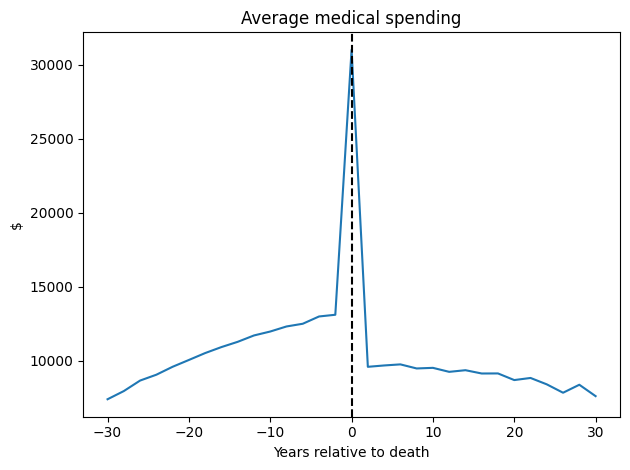

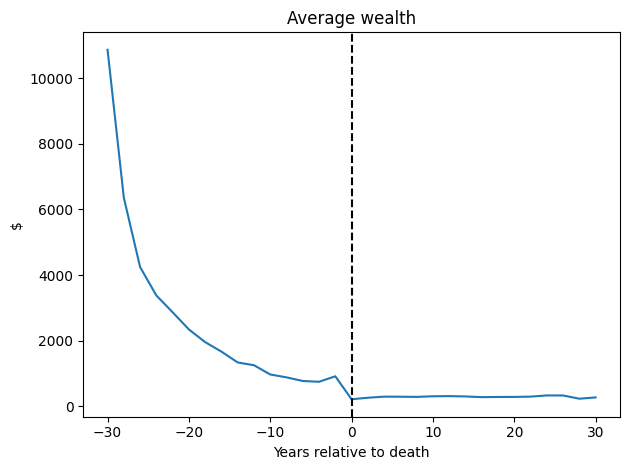

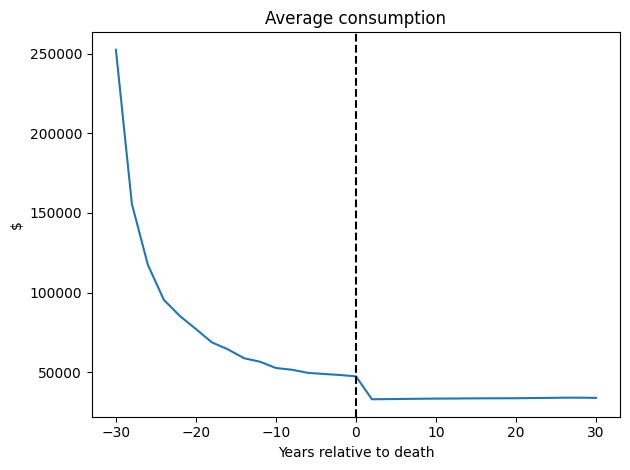

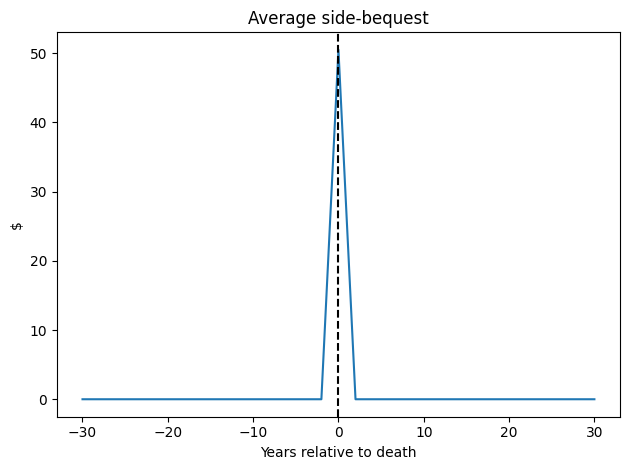

Simulation finished: 152717 rows


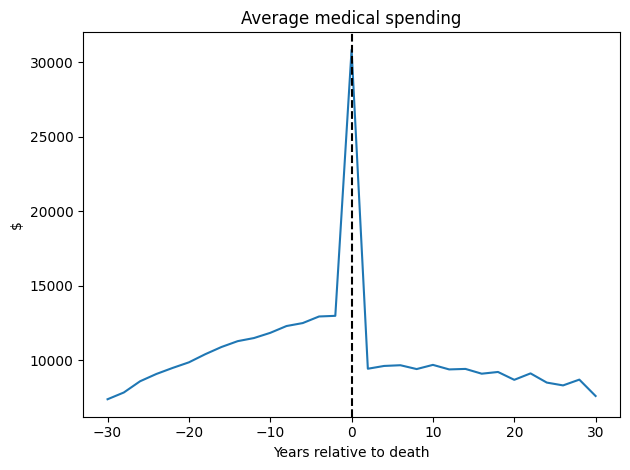

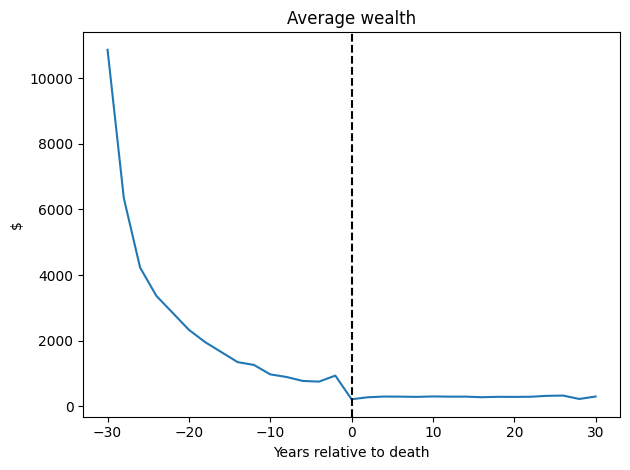

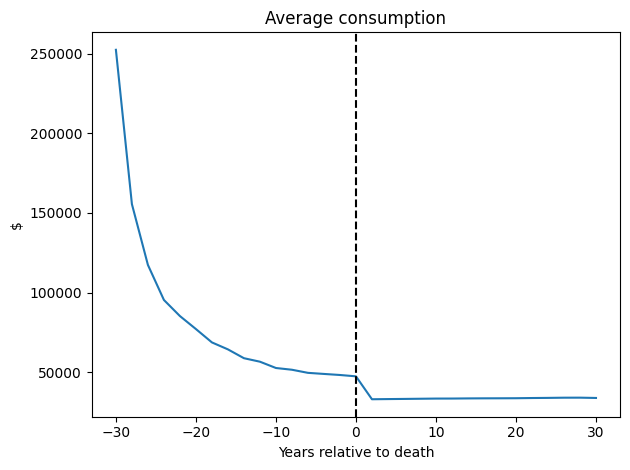

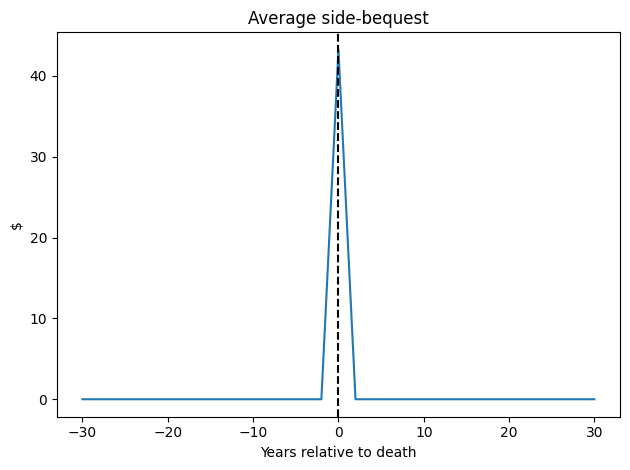

In [23]:
import matplotlib.pyplot as plt

# helper: nearest‑left index
# helper: nearest‑left index
def idx(grid, x):
    return int(np.clip(np.searchsorted(grid, x, side='right') - 1, 0, len(grid)-1))

# overwrite Household.step to pull from policy arrays
def step_opt(self, t:int, rng=np.random.default_rng()):
    if not (self.aliveH or self.aliveW):
        return

    age_idx_t = age_idx[self.age]
    a_idx = idx(A_grid, self.wealth)
    i_idx = idx(I_grid, self.pi)

    # ---- pull optimal policies ----
    if self.family == Family.C and self.aliveH and self.aliveW:
        hH, hW = self.hH, self.hW
        c_opt = C_C[age_idx_t, a_idx, i_idx, hH, hW]
        s_opt = S_C[age_idx_t, a_idx, i_idx, hH, hW]
    else:
        h_single = self.hH if self.aliveH else self.hW
        c_opt = C_S[age_idx_t, a_idx, i_idx, h_single]
        s_opt = 0.0

    # ---- incomes & cash ----
    y = 2 * annuitised_income(self.pi, self.family, self.age)
    cash = self.wealth * R + y
    floor = parameters["cmin_couple_annual"]*2 if self.married else parameters["cmin_single_annual"]*2
    c = max(c_opt, floor)      # ensure floor

    # ---- mortality ----
    qH = mort_hazard_annual(self.age, Family.SM)*2 if self.aliveH else 1.0
    deadH = self.aliveH and (rng.random() < qH)
    qW = mort_hazard_annual(self.age, Family.SW)*2 if self.aliveW else 1.0
    deadW = self.aliveW and (rng.random() < qW)

    # ---- medical expenses ----
    med = medical_expense_stub(self.hH, deadH, rng)
    if self.married:
        med += medical_expense_stub(self.hW, deadW, rng)

    A_after = max(cash - c - med, 0.0)

    # ---- side bequest if one spouse dies ----
    beq_side = 0.0
    if deadH ^ deadW and self.family == Family.C:
        beq_side = s_opt * A_after
        A_after *= (1 - s_opt)

    # ---- update states ----
    if deadH: self.aliveH = False
    if deadW: self.aliveW = False
    if (deadH or deadW) and self.family == Family.C and not self.married:
        self.family = Family.SW if self.aliveW else Family.SM

    if self.aliveH:
        self.hH = health_transition_stub(self.hH)
    if self.aliveW:
        self.hW = health_transition_stub(self.hW)

    # log
    self.log.append(dict(hid=self.hid, t=t, age=self.age, family=self.family.name,
                         wealth=A_after, cons=c, medical=med,
                         beq_side=beq_side, death=(deadH or deadW)))

    # advance
    self.age    += 2
    self.wealth = A_after

# patch the method
Household.step = step_opt

# ---------- simulate ----------
def simulate_opt_cohort(N=10_000, periods=len(ages)-1, seed=2025):
    rng = np.random.default_rng(seed)
    hh_list = [
        Household(hid=i,
                  age=72,
                  pi=int(rng.integers(10, 91)),
                  family=Family.C if rng.random()<0.5 else Family.SM,
                  wealth=float(rng.uniform(50_000, 400_000)))
        for i in range(N)
    ]
    for t in range(periods):
        for hh in hh_list:
            hh.step(t, rng)

    return pd.DataFrame(rec | dict(hid=hh.hid)
                        for hh in hh_list for rec in hh.log)

pop = simulate_opt_cohort()
print("Simulation finished:", pop.shape[0], "rows")

# ---------- event‑study plots ----------
evt = pop.copy()
# identify first death event per household
evt['event_time'] = None
evt_first = evt[evt['death']].groupby('hid')['t'].min()
evt = evt.join(evt_first.rename('t0'), on='hid')
evt['event_time'] = evt['t'] - evt['t0']

# only rows with defined event_time
evt = evt.dropna(subset=['event_time'])

def plot_series(series, title, ylabel):
    plt.figure()
    plt.plot(series.index*2, series.values)
    plt.axvline(0, ls='--', color='k')
    plt.title(title); plt.xlabel("Years relative to death"); plt.ylabel(ylabel)
    plt.tight_layout()

plot_series(evt.groupby('event_time')['medical'].mean().sort_index(),
            "Average medical spending", "$")
plot_series(evt.groupby('event_time')['wealth'].mean().sort_index(),
            "Average wealth", "$")
plot_series(evt.groupby('event_time')['cons'].mean().sort_index(),
            "Average consumption", "$")
plot_series(evt.groupby('event_time')['beq_side'].mean().sort_index(),
            "Average side‑bequest", "$")
plt.show()

def idx(grid, x):
    return int(np.clip(np.searchsorted(grid, x, side='right') - 1, 0, len(grid)-1))

# overwrite Household.step to pull from policy arrays
def step_opt(self, t:int, rng=np.random.default_rng()):
    if not (self.aliveH or self.aliveW):
        return

    age_idx_t = age_idx[self.age]
    a_idx = idx(A_grid, self.wealth)
    i_idx = idx(I_grid, self.pi)

    # ---- pull optimal policies ----
    if self.family == Family.C and self.aliveH and self.aliveW:
        hH, hW = self.hH, self.hW
        c_opt = C_C[age_idx_t, a_idx, i_idx, hH, hW]
        s_opt = S_C[age_idx_t, a_idx, i_idx, hH, hW]
    else:
        h_single = self.hH if self.aliveH else self.hW
        c_opt = C_S[age_idx_t, a_idx, i_idx, h_single]
        s_opt = 0.0

    # ---- incomes & cash ----
    y = 2 * annuitised_income(self.pi, self.family, self.age)
    cash = self.wealth * R + y
    floor = parameters["cmin_couple_annual"]*2 if self.married else parameters["cmin_single_annual"]*2
    c = max(c_opt, floor)      # ensure floor

    # ---- mortality ----
    qH = mort_hazard_annual(self.age, Family.SM)*2 if self.aliveH else 1.0
    deadH = self.aliveH and (rng.random() < qH)
    qW = mort_hazard_annual(self.age, Family.SW)*2 if self.aliveW else 1.0
    deadW = self.aliveW and (rng.random() < qW)

    # ---- medical expenses ----
    med = medical_expense_stub(self.hH, deadH, rng)
    if self.married:
        med += medical_expense_stub(self.hW, deadW, rng)

    A_after = max(cash - c - med, 0.0)

    # ---- side bequest if one spouse dies ----
    beq_side = 0.0
    if deadH ^ deadW and self.family == Family.C:
        beq_side = s_opt * A_after
        A_after *= (1 - s_opt)

    # ---- update states ----
    if deadH: self.aliveH = False
    if deadW: self.aliveW = False
    if (deadH or deadW) and self.family == Family.C and not self.married:
        self.family = Family.SW if self.aliveW else Family.SM

    if self.aliveH:
        self.hH = health_transition_stub(self.hH)
    if self.aliveW:
        self.hW = health_transition_stub(self.hW)

    # log
    self.log.append(dict(hid=self.hid, t=t, age=self.age, family=self.family.name,
                         wealth=A_after, cons=c, medical=med,
                         beq_side=beq_side, death=(deadH or deadW)))

    # advance
    self.age    += 2
    self.wealth = A_after

# patch the method
Household.step = step_opt

# ---------- simulate ----------
def simulate_opt_cohort(N=10_000, periods=len(ages)-1, seed=2025):
    rng = np.random.default_rng(seed)
    hh_list = [
        Household(hid=i,
                  age=72,
                  pi=int(rng.integers(10, 91)),
                  family=Family.C if rng.random()<0.5 else Family.SM,
                  wealth=float(rng.uniform(50_000, 400_000)))
        for i in range(N)
    ]
    for t in range(periods):
        for hh in hh_list:
            hh.step(t, rng)

    return pd.DataFrame(rec | dict(hid=hh.hid)
                        for hh in hh_list for rec in hh.log)

pop = simulate_opt_cohort()
print("Simulation finished:", pop.shape[0], "rows")

# ---------- event‑study plots ----------
evt = pop.copy()
# identify first death event per household
evt['event_time'] = None
evt_first = evt[evt['death']].groupby('hid')['t'].min()
evt = evt.join(evt_first.rename('t0'), on='hid')
evt['event_time'] = evt['t'] - evt['t0']

# only rows with defined event_time
evt = evt.dropna(subset=['event_time'])

def plot_series(series, title, ylabel):
    plt.figure()
    plt.plot(series.index*2, series.values)
    plt.axvline(0, ls='--', color='k')
    plt.title(title); plt.xlabel("Years relative to death"); plt.ylabel(ylabel)
    plt.tight_layout()

plot_series(evt.groupby('event_time')['medical'].mean().sort_index(),
            "Average medical spending", "$")
plot_series(evt.groupby('event_time')['wealth'].mean().sort_index(),
            "Average wealth", "$")
plot_series(evt.groupby('event_time')['cons'].mean().sort_index(),
            "Average consumption", "$")
plot_series(evt.groupby('event_time')['beq_side'].mean().sort_index(),
            "Average side‑bequest", "$")
plt.show()

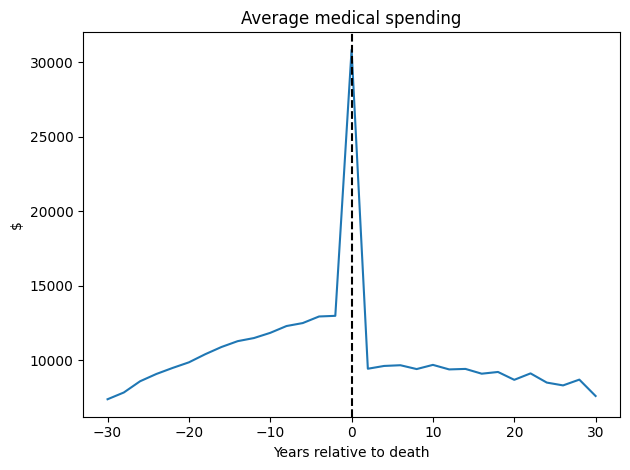

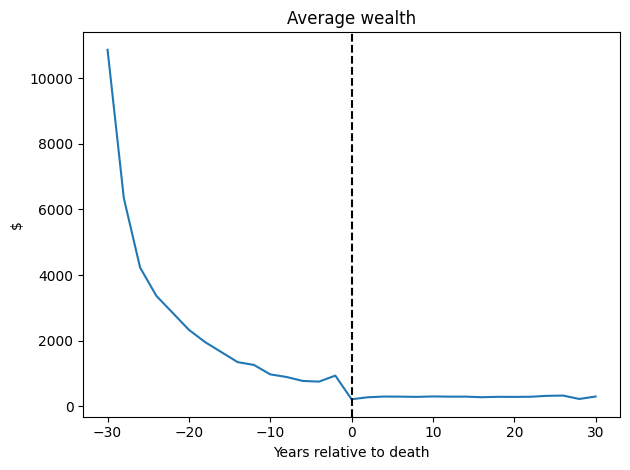

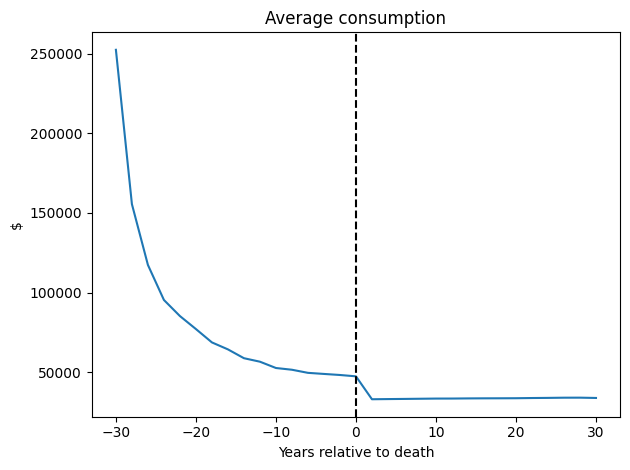

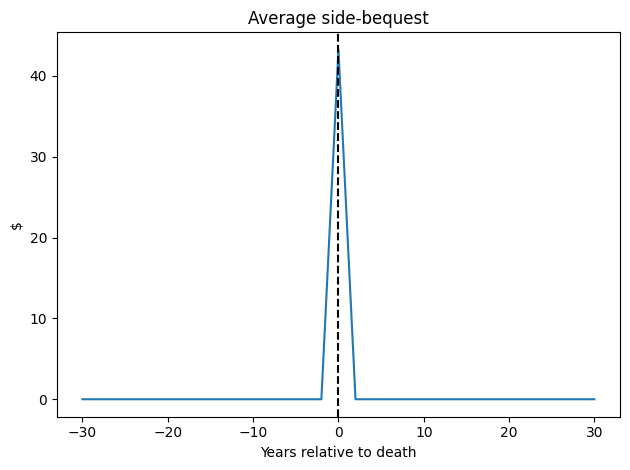

In [24]:
# ---------- event‑study plots ----------
evt = pop.copy()
# identify first death event per household
evt['event_time'] = None
evt_first = evt[evt['death']].groupby('hid')['t'].min()
evt = evt.join(evt_first.rename('t0'), on='hid')
evt['event_time'] = evt['t'] - evt['t0']

# only rows with defined event_time
evt = evt.dropna(subset=['event_time'])

def plot_series(series, title, ylabel):
    plt.figure()
    plt.plot(series.index*2, series.values)
    plt.axvline(0, ls='--', color='k')
    plt.title(title); plt.xlabel("Years relative to death"); plt.ylabel(ylabel)
    plt.tight_layout()

plot_series(evt.groupby('event_time')['medical'].mean().sort_index(),
            "Average medical spending", "$")
plot_series(evt.groupby('event_time')['wealth'].mean().sort_index(),
            "Average wealth", "$")
plot_series(evt.groupby('event_time')['cons'].mean().sort_index(),
            "Average consumption", "$")
plot_series(evt.groupby('event_time')['beq_side'].mean().sort_index(),
            "Average side‑bequest", "$")
plt.show()